# Uppgift 3 - Bildklassificering 

I denna uppgiften ska ni testa på att klassificera bilder mha 2 (3) olika tekniker:
* SVM - Support vector machines
* Fully-connected Neural Network (FC)
* Convolutional Neural Network (CNN)

Ni ska jämföra resultaten på test-setet utifrån bl.a. hur mycket data som användes för att träna de olika modellerna. Ni ska **kommentera koden** som ni skriver med korta förklaringar på vad koden gör.

Datasetet som ni kommer använda er av är ett subset av data från MNIST och innehåller handskrivna siffror från 0-9 i gråskala [0-255]. Datan är uppdelad i två filer, **train.csv** och **test.csv**, som finns tillsammans med uppgiften på Canvas.

Till er hjälp så är det meningen att ni ska använda er av följande paket:
* torch --- Huvudpaketet för ''pytorch'', används för att implementera och träna neurala nät.
* torchvision --- Stödpaket för ''pytorch'', används för att hantera data.
* sklearn --- Huvudpaketet för ''scikit-learn'', används för att implementera SVM:s.
* matplotlib --- Verktyg för att plotta grafer/bilder.
* pandas --- Verktyg för datahantering
* numpy --- Verktyg för datahantering/matris-manipulering

Paketen kan installeras på olika sätt, exempelvis genom Python-verktyget pip, och det kan då se ut såhär:

<pre><code> pip install torch </pre></code>

eller

<pre><code> pip3 install scikit-learn </pre></code>

Vi rekommenderar att ni gör detta i en virtuell Python-miljö via exempelvis Anaconda och med Python-version 3.8.*.

Paketen och klasserna som ska importeras är fördefinierade här under.

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score 

### Uppgift 1 -  Ladda data

1. Ladda in datan från de två filerna med hjälp av **pandas** och spara i varsin DataFrame, train_df & test_df.
2. Dela upp träningsdatan i två delar, en för träning och en för validering, genom att specificera storleken på träningsdatan n_training_large. Skapa även en kopia av träningsdatan där endast de första 1000 datapunkterna ingår. Använd samma valideringsdata för alla modeller.
3. Ge en kort motivering till varför ni valt just detta värdet på **n_training_large**. 
4. Ta reda på vilken column i datan som innehåller svaret på vilken klass en bild tillhör och printa det.

In [3]:
# Uppgift 1.1

# Load the two files into dataframes using pandas and store 
train_df = pd.read_csv("train.csv")  #load training data
test_df = pd.read_csv("test.csv")    #load test data




In [4]:
# Uppgift 1.2

# Separate the data into a suitable split between training and validation
# by specifing the number of samples in the training set, n_training_data.
n_training_small = 1000
n_training_large = 25600 # CODE HERE


print('Training data - small: {}'.format(n_training_small))
print('Training data - large: {}'.format(n_training_large))
print('Validation data: {}'.format(len(train_df) - n_training_large))
print('Test data: {}'.format(len(test_df)))

Training data - small: 1000
Training data - large: 25600
Validation data: 6398
Test data: 10002


Ge en kort motivering till valet av storleken på **n_training_large**

In [4]:
# Uppgift 1.3

# ANSWER HERE """"""" Tror Abbe"""""""
### För att inte modellen ska ha en overfittings inlärning så har vi valt att lära den med 80% av den data som står för att sedan ha en bra accuracy vid inlärning 

In [5]:
# This code separates the data into two parts according to the size of the training data, n_training_large & n_training_small,
# specified above.
val_df = train_df.iloc[n_training_large:, :].copy()
train_df_small = train_df.iloc[0:n_training_small, :].copy()
train_df = train_df.iloc[0:n_training_large, :].copy()

In [6]:
# Printing the shape of the data
print(train_df.shape)
print(train_df_small.shape)
print(val_df.shape)
print(test_df.shape)

(25600, 785)
(1000, 785)
(6398, 785)
(10002, 785)


In [7]:
# Uppgift 1.4

# Figure out which column that contains the labels (classes) and print it here
# CODE HERE
train_df["label"]

0        1
1        0
2        1
3        4
4        0
        ..
25595    5
25596    2
25597    0
25598    7
25599    2
Name: label, Length: 25600, dtype: int64

### Uppgift 2 - Formatera data

Kod för att bearbeta data kan snabbt bli rörig och svår att underhålla och bör därför inte hänga ihop med koden som tränar nätverken. Detta ger också bättre läsbarhet och ökad modularitet. PyTorch tillhandahåller två hjälp-klasser: **torch.utils.data.DataLoader** och **torch.utils.data.Dataset** som låter dig ladda in färdiga dataset samt skapa egna. Klassen **Dataset** lagrar datapunkterna och deras motsvarande labels och **DataLoader** gör om datasetet till en *iterable* för att göra det enkelt att använda datapunkterna. I koden i blocket nedan så ser ni skelettet till ett egenskapat dataset, **MNISTDataset**, som ärver klassen **Dataset**. 


1. Gör klart implementationen av Dataset-klassen **MNISTDataset** genom att skriva kod som separerar datan i labels och features samt normaliserar datan och gör om den till matriser som motsvarar bilder av storleken 28x28 pixlar.
2. Skapa 4 dataset utifrån train_df, train_df_small, val_df och test_df.
3. Bestäm storlekarna på batcherna som ska användas vid träning respektive testning och skapa 4 DataLoaders för de fyra dataseten ovan. Träningsdatan ska slumpas men inte validering och test.
4. Plotta ett par exempelbilder och deras labels mha **matplotlib** och DataLoadern för träningssetet.

In [8]:


class MNISTDataset(Dataset): 
  def __init__(self, df):
    # Separate the labels and the pixel values into the arrays y and x, respectively.
    # CODE HERE
    y = df['label'].values
    x = df.drop(columns = ['label']).values
    # Normalize the x-values and transform the data into images of size (color channels, width, height), i.e. w(1, 28, 28).
    # CODE HERE
    x = x/255
    x = x.reshape(len(x),1,28,28)
    
    # the numpy arrays are converted into tensors that will be used in the training and testing of the network
    self.x=torch.tensor(x,dtype=torch.float32)
    self.y=torch.tensor(y)
    
  def __len__(self):
    # returns the number of samples in the dataset
    return len(self.y)
  
  def __getitem__(self, idx):
    # returns a sample from the dataset at the given index idx
    return self.x[idx], self.y[idx]

  


In [9]:
# Uppgift 2.2

# Create four datasets, from the dataframes defined earlier, using the MNISTDataset class
train_dataset = MNISTDataset(train_df)
train_dataset_small = MNISTDataset(train_df_small)
val_dataset = MNISTDataset(val_df)
test_dataset = MNISTDataset(test_df)


In [10]:
# Uppgift 2.3

# Specify the batch_sizes to use for training and testing
batch_size_train = 128
batch_size_test = 1

# Create four DataLoaders from the four datasets above. Shuffle the training data but not the others.
train_dload = DataLoader(train_dataset, batch_size = batch_size_train, shuffle=True)
train_dload_small = DataLoader(train_dataset_small, batch_size = batch_size_train, shuffle=True)
val_dload = DataLoader(val_dataset, batch_size = batch_size_train, shuffle=True)
test_dload = DataLoader(test_dataset, batch_size = batch_size_test, shuffle=True)

val_dload

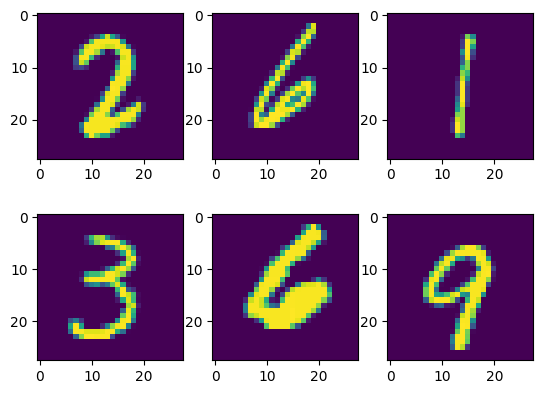

In [11]:
# Uppgift 2.4

# Plot images and labels for a few examples using the DataLoader for the training set.
# CODE HERE

fig, (ax1, ax2) = plt.subplots(2,3)

images, labels  = next(iter(train_dload))



for index in range(3):
    ax1[index].imshow(images[index].reshape((28, 28, -1)))
    ax2[index].imshow(images[index+100].reshape((28, 28,-1)))


### Uppgift 3 - Bygga dense-nätverk

Det första neurala nätverket vi ska skapa är ett så kallat Fully-connected/Dense Neural Network och består därför endast av lager där alla neuroner i ett lager är sammankopplade med alla neuroner från lagret innan. I **pytorch** så kan man skapa sin egen klass för ett nätverk genom att ärva *nn.Module* och implementera en *__ init__()* samt en *forward()* metod.

Ett lager av typen FC skapas i **pytorch** med hjälp av *nn.Linear* enligt exemplet nedan. 
<pre><code> nn.Linear(nr_of_input_neurons, nr_of_output_neurons) </pre></code>
De viktigaste input-parametrarna är antalet neuroner i lagret innan, **nr_of_input_neurons**, samt hur många neuroner detta lagret ska ha, **nr_of_output_neurons**. Mer information hittar ni i dokumentationen: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

I dokumentationen hittar ni också information om olika aktiveringsfunktioner: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

När nätverket är färdigt så är nästa steg att bestämma sin loss-funktion samt learning rate och optimerare.

1. Gör klart nätverket.
2. Välj loss-funktion, learning rate och optimizers.

In [12]:
# Uppgift 3.1

class DenseNet(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super().__init__()

        # Add more Linear (FC/Dense) layers here and experiment with different number of neurons.
        self.fc_in = nn.Linear(input_size, 128)
        self.layer_1 = nn.Linear(self.fc_in.out_features, 128)
        self.layer_2 = nn.Linear(self.layer_1.out_features, 128)
        self.fc_out = nn.Linear(self.layer_2.out_features, num_classes)
        
        self.activationmid = nn.ReLU()
        self.activationout = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Reshapes the input of size (batch x 1x28x28) into a vector (batch x784)
        x = x.view(x.shape[0], -1)

        x = self.activationmid(self.fc_in(x))
        x = self.activationmid(self.layer_1(x))
        x = self.activationmid(self.layer_2(x))
        x = self.activationout(self.fc_out(x))

        return x

In [13]:
# Create the network
dense_net = DenseNet()

# Printing the network gives an overview of the network structure
print(dense_net)
# and calculating the nuber of parameters gives the size of the network
print('Number of parameters: {}'.format(sum([param.nelement() for param in dense_net.parameters()])))


DenseNet(
  (fc_in): Linear(in_features=784, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (activationmid): ReLU()
  (activationout): LogSoftmax(dim=1)
)
Number of parameters: 134794


Bestäm en learning rate, vilken loss-funktion samt vilken optimerare som ska användas för att lösa uppgiften.

Loss-funktioner hittar man i modulen **nn** på följande sätt: 

<pre><code> nn.NamnetPåLossFunktionen() </pre></code>

där de olika varianterna hittas här https://pytorch.org/docs/stable/nn.html#loss-functions

och optimerare:

<pre><code> optim.NamnetPåOptimeraren() </pre></code>

som hittas här https://pytorch.org/docs/stable/optim.html

In [ ]:
# Uppgift 3.2

learning_rate = 0.1
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_net.parameters() , lr = learning_rate)

In [52]:


# Create the network for small data
dense_net_small = DenseNet()

# Printing the network gives an overview of the network structure
print(dense_net_small)
# and calculating the nuber of parameters gives the size of the network
print('Number of parameters: {}'.format(sum([param.nelement() for param in dense_net_small.parameters()])))


DenseNet(
  (fc_in): Linear(in_features=784, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (activationmid): ReLU()
  (activationout): LogSoftmax(dim=1)
)
Number of parameters: 134794


In [53]:
# Uppgift 3.2

learning_rate = 0.1
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_net_small.parameters() , lr = learning_rate)

### Uppgift 4 - Träna och evaluera dense-nätverk

Träning av nätverket innebär att vi i epoker (upprepade omgångar) låter nätverket gissa klassen på samtliga våra bilder i träningsdatan. Felet och dess gradienterna för samtliga parametrar beräknas mha loss-funktionen och nätverket uppdateras sen utifrån gradienterna av optimeraren.

1. Skriv en funktion *train(network, epoch, dataset)* som tar emot nätverket, numret på en epok samt träningsdata och utför träning av nätverket i batcher tills all data har gåtts igenom en gång. Beräkna gradienterna och uppdatera värdet.
2. Skriv en funktion *test(dataset)* som beräknar average loss och accuracy för nätverket på ett angivet dataset och sedan printar detta. Funktionen ska returnera snitt-felet som ett värde.
3. Experimentera er fram till ett nätverk som presterar bra (>96% accuracy) på det stora träningssetet och jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet.

Nedan följer en beskrivning i text av vad *train* ska göra:

<pre><code> 
funktion train(network, epoch, dataset)
    Sätt nätverket i träningsläge
    För varje batch i datasetet
        Nollställ optimerarens gradienter    
        Beräkna nätverkets gissningar utifrån batchen med data
        Beräkna felet mha loss-funktionen och true-labels/targets
        Beräkna fel-gradienterna för samtliga parametrar
        Uppdatera nätverket mha optimeraren
        
        För vissa batcher, printa info om hur träningen går, exempelvis batch, loss och procent av epoken som är klar.
</pre></code>

In [15]:
# Uppgift 4.1

def train(network, epoch, dataset):
    network.train(mode= True)
    totloss = 0
    for i, (features, targets) in enumerate(dataset):
        # print("features",features[0], "targets", targets[0])
        optimizer.zero_grad()
        output = network.forward(features)
        loss = loss_function(output, targets)
        totloss += loss.item()
        totloss/= targets.size()[0]
        loss.backward()
        optimizer.step()
       
        if i % 50 == 0 :
            print(f" epoch nummer { epoch } klar  {i/len(dataset) * 100} %, loss => {format(loss)}")
        


Nedan följer en beskrivning i text av vad *test* ska göra:

<pre><code> 
funktion test(network, dataset)
    y_true = []
    y_pred = []
    
    Sätt nätverket i evalueringsläge
    Stäng av användningen av gradienter
        För varje batch i datasetet
            Beräkna nätverkets gissningar utifrån batchen med data
            Beräkna felet mha loss-funktionen och true-labels/targets
            Spara gissningarna i y_pred
            Spara de rätta svaren i y_true
            
    Använd y_pred och y_true för att beräkna accuracy och skapa en confusion matrix
    Printa Avg. loss, accuracy och en confusion matrix
    Returnera Avg. loss
</pre></code>

In [16]:
# Uppgift 4.2

def test(network, dataset):
    #-----------------tror att det är så 
      Y_true=[]
      Y_pred=[]
      totloss = 0
      val_loss_arr = []
      # network.train(mode= False)
      network.eval()
      
      with torch.no_grad(): 
        for data in dataset: 
          inputs, labels = data 
          predicted_outputs = network.forward(inputs)
          
          val_loss = loss_function(predicted_outputs, labels) 
          
          totloss += val_loss.item()
          totloss/= labels.size()[0]
          
          val_loss_arr.append(val_loss)
          for out, lab in zip(predicted_outputs,labels):
                Y_pred.append(torch.argmax(out))
                Y_true.append(lab) 
          
        cm = metrics.confusion_matrix(Y_true, Y_pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm)
        disp.plot()
        plt.show()
        print("Avg loss = ", totloss , " Accuracy = ", metrics.accuracy_score(Y_true, Y_pred))
        return totloss
        
      

Det som är kvar nu är att träna nätverket i flera omgångar (epoker) och kontinuerligt utvärdera hur träningen går mha valideringsdatan. Varje gång en ny lägsta (bästa) loss uppnås så kan modellen och optimeraren sparas för att användas igen senare.

 epoch nummer 1 klar  0.0 %, loss => 2.30519700050354
 epoch nummer 1 klar  25.0 %, loss => 2.249765396118164
 epoch nummer 1 klar  50.0 %, loss => 1.670981764793396
 epoch nummer 1 klar  75.0 %, loss => 0.7312172651290894


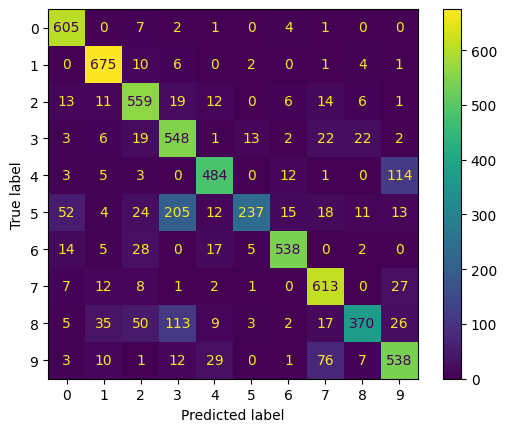

Avg loss =  0.004150580055777817  Accuracy =  0.807596123788684
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 2 klar  0.0 %, loss => 0.7117308974266052
 epoch nummer 2 klar  25.0 %, loss => 0.380193829536438
 epoch nummer 2 klar  50.0 %, loss => 0.5002546310424805
 epoch nummer 2 klar  75.0 %, loss => 0.2996715009212494


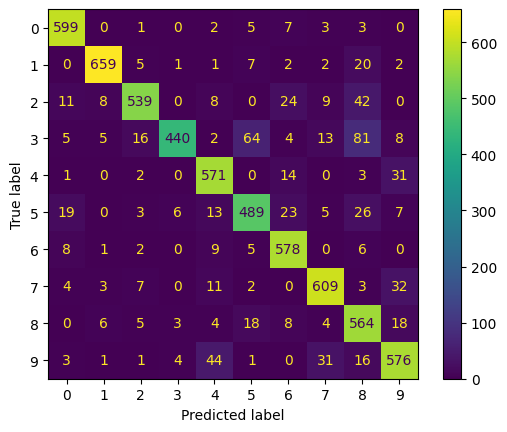

Avg loss =  0.0035668328705926555  Accuracy =  0.8790246952172553
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 3 klar  0.0 %, loss => 0.4388859272003174
 epoch nummer 3 klar  25.0 %, loss => 0.308723121881485
 epoch nummer 3 klar  50.0 %, loss => 0.4062897264957428
 epoch nummer 3 klar  75.0 %, loss => 0.3978961408138275


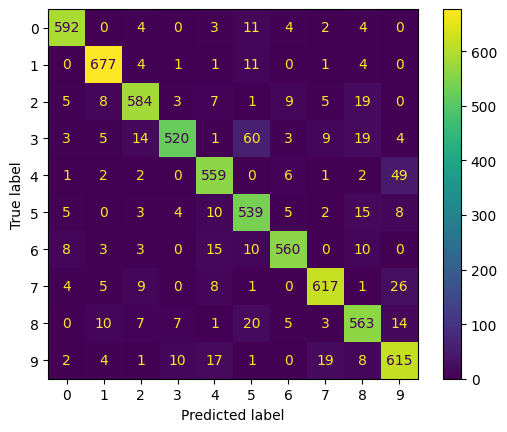

Avg loss =  0.0020539742282305188  Accuracy =  0.9105970615817442
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 4 klar  0.0 %, loss => 0.16010229289531708
 epoch nummer 4 klar  25.0 %, loss => 0.22557306289672852
 epoch nummer 4 klar  50.0 %, loss => 0.22051368653774261
 epoch nummer 4 klar  75.0 %, loss => 0.25555047392845154


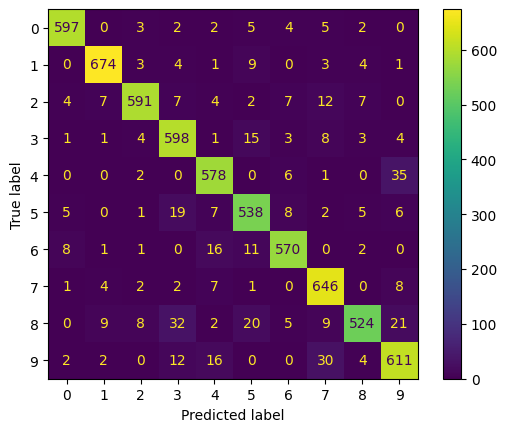

Avg loss =  0.0013188563158998815  Accuracy =  0.9263832447639887
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 5 klar  0.0 %, loss => 0.2619393765926361
 epoch nummer 5 klar  25.0 %, loss => 0.26209282875061035
 epoch nummer 5 klar  50.0 %, loss => 0.17662310600280762
 epoch nummer 5 klar  75.0 %, loss => 0.18260176479816437


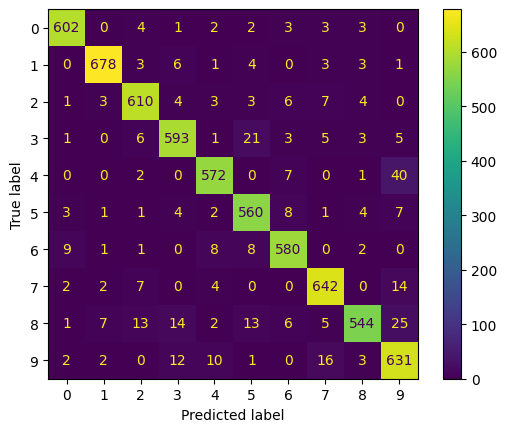

Avg loss =  0.0013166157343745787  Accuracy =  0.9396686464520163
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 6 klar  0.0 %, loss => 0.2359330952167511
 epoch nummer 6 klar  25.0 %, loss => 0.1853545904159546
 epoch nummer 6 klar  50.0 %, loss => 0.17605525255203247
 epoch nummer 6 klar  75.0 %, loss => 0.16593001782894135


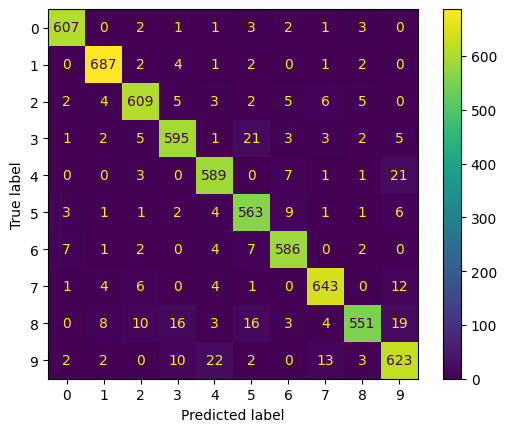

Avg loss =  0.0010906762633261964  Accuracy =  0.9460768990309472
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 7 klar  0.0 %, loss => 0.121158167719841
 epoch nummer 7 klar  25.0 %, loss => 0.13916923105716705
 epoch nummer 7 klar  50.0 %, loss => 0.08445148169994354
 epoch nummer 7 klar  75.0 %, loss => 0.2232208400964737


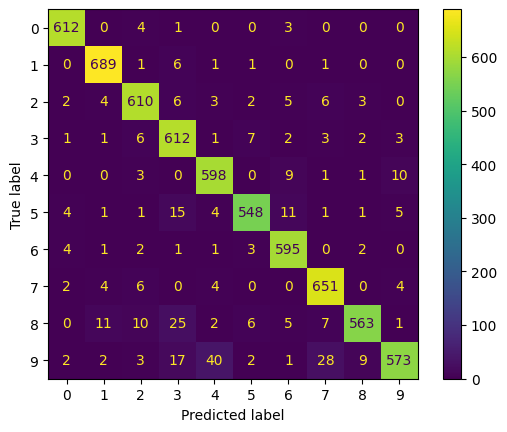

Avg loss =  0.0019926166890643186  Accuracy =  0.94576430134417
 epoch nummer 8 klar  0.0 %, loss => 0.19372379779815674
 epoch nummer 8 klar  25.0 %, loss => 0.06839312613010406
 epoch nummer 8 klar  50.0 %, loss => 0.12616224586963654
 epoch nummer 8 klar  75.0 %, loss => 0.08463571965694427


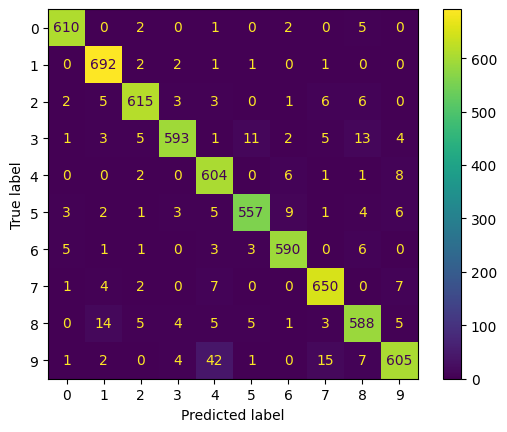

Avg loss =  0.0009577324962075071  Accuracy =  0.9540481400437637
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 9 klar  0.0 %, loss => 0.06278055906295776
 epoch nummer 9 klar  25.0 %, loss => 0.09102023392915726
 epoch nummer 9 klar  50.0 %, loss => 0.13314500451087952
 epoch nummer 9 klar  75.0 %, loss => 0.08762182295322418


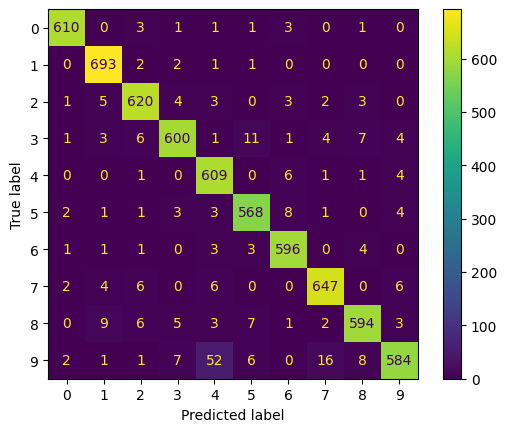

Avg loss =  0.0014513006587091493  Accuracy =  0.9567052203813692
 epoch nummer 10 klar  0.0 %, loss => 0.10470706969499588
 epoch nummer 10 klar  25.0 %, loss => 0.07102059572935104
 epoch nummer 10 klar  50.0 %, loss => 0.0689065232872963
 epoch nummer 10 klar  75.0 %, loss => 0.09448583424091339


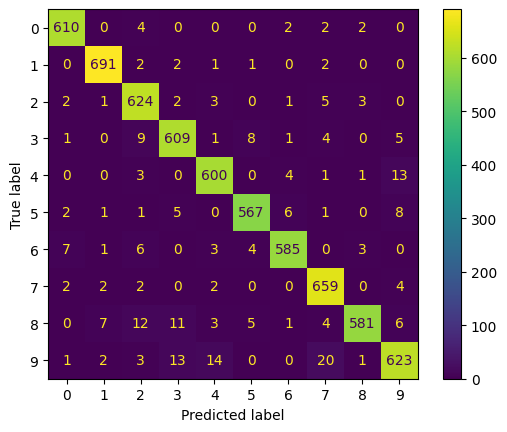

Avg loss =  0.000589011778936946  Accuracy =  0.9610815879962489
Saving best model to ./results/net_filemame.txt.pth



In [17]:
n_epochs = 10
net_filename = "net_filemame.txt"
opti_filename = "opti1"
best_loss = 10 ** 4

for epoch in range(1, n_epochs + 1):
    # Perform training once on the entire set of training data
    train(dense_net, epoch, train_dload)  
    
    # Evaluate the net using validation data
    val_loss = test(dense_net, val_dload)
    
    # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
    # can always be retrieved afterwards. 
    if val_loss < best_loss:
        print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))
        
        # Save the network
        torch.save(dense_net.state_dict(), './results/{}.pth'.format(net_filename))
        # Save the optimizer, in case we want to continue training later
        torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
        # Update the best loss to the current loss
        best_loss = val_loss

Ett sparat nätverk kan sedan laddas in med *torch.load(filename)* enligt koden nedan.

 epoch nummer 1 klar  0.0 %, loss => 0.19059960544109344


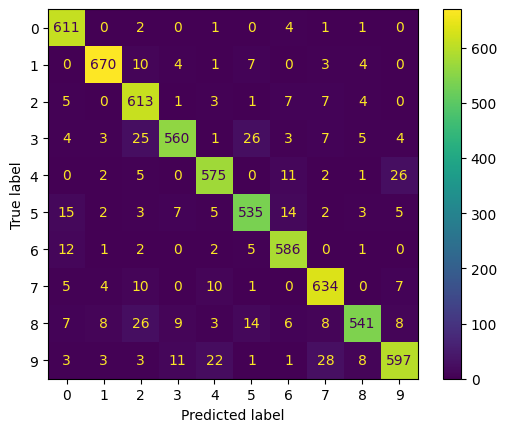

Avg loss =  0.0020012161967602406  Accuracy =  0.925601750547046
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 2 klar  0.0 %, loss => 0.13245318830013275


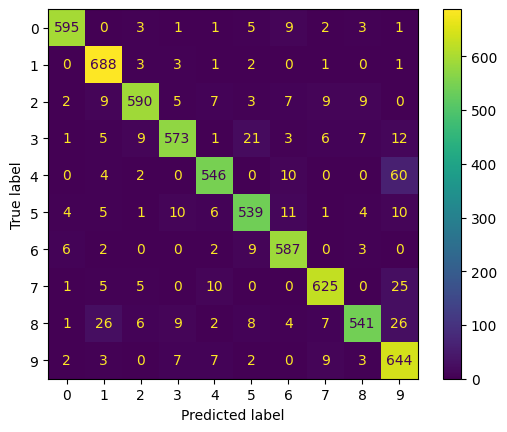

Avg loss =  0.001954876436427454  Accuracy =  0.9265395436073773
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 3 klar  0.0 %, loss => 0.1788063794374466


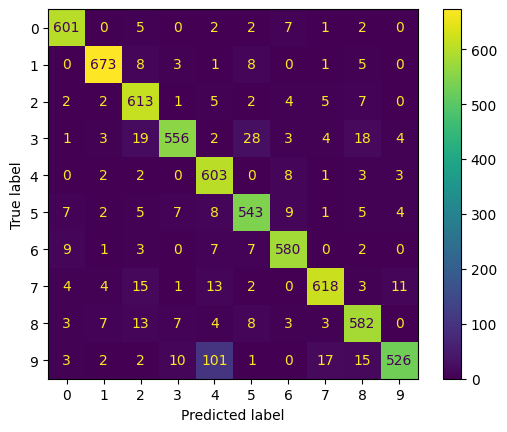

Avg loss =  0.0023559454146326823  Accuracy =  0.9213816817755549
 epoch nummer 4 klar  0.0 %, loss => 0.1954558938741684


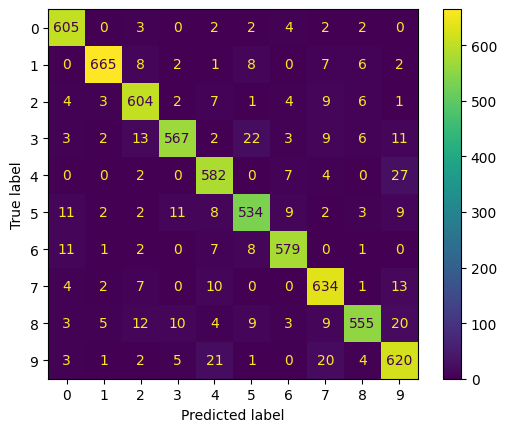

Avg loss =  0.001703877308407726  Accuracy =  0.9291966239449828
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 5 klar  0.0 %, loss => 0.07139334082603455


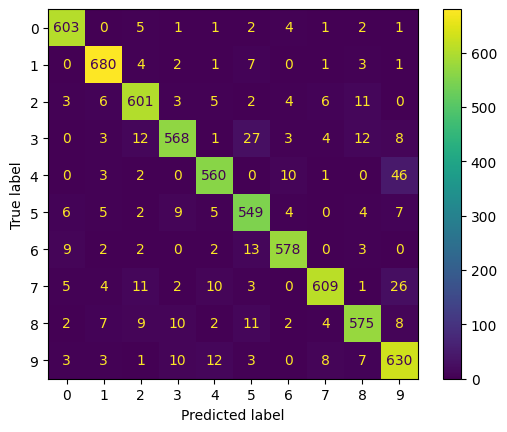

Avg loss =  0.0019963250916134948  Accuracy =  0.9304470146920912
 epoch nummer 6 klar  0.0 %, loss => 0.08235097676515579


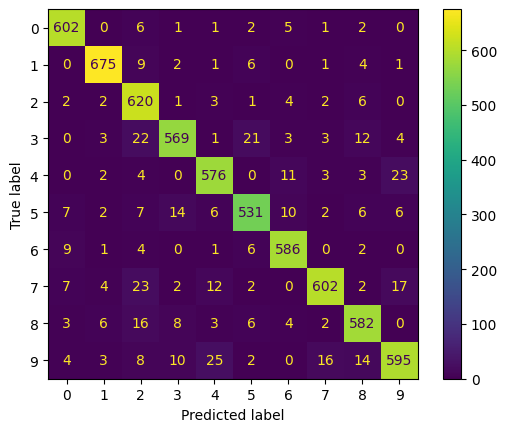

Avg loss =  0.002144964290005114  Accuracy =  0.9281025320412629
 epoch nummer 7 klar  0.0 %, loss => 0.16057687997817993


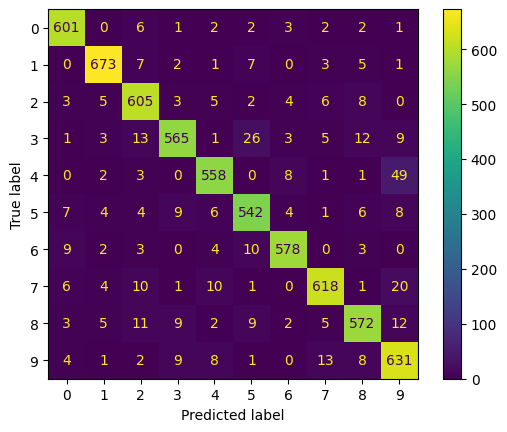

Avg loss =  0.0024671016182025753  Accuracy =  0.9288840262582057
 epoch nummer 8 klar  0.0 %, loss => 0.11404639482498169


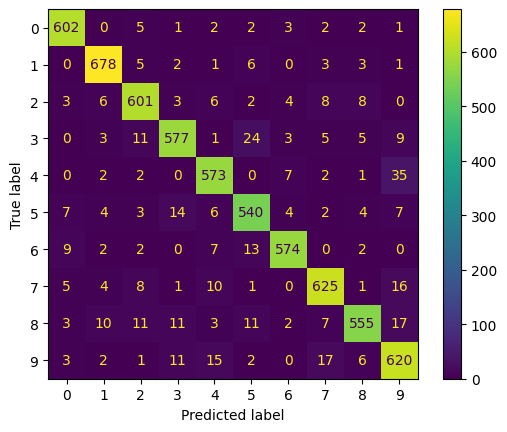

Avg loss =  0.0012182918288549016  Accuracy =  0.9291966239449828
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 9 klar  0.0 %, loss => 0.07281610369682312


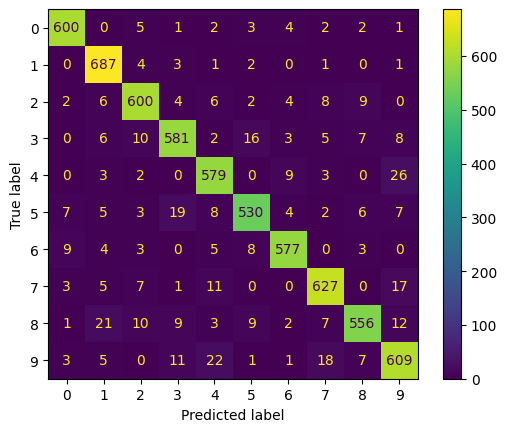

Avg loss =  0.0019889019255170076  Accuracy =  0.9293529227883713
 epoch nummer 10 klar  0.0 %, loss => 0.06988789886236191


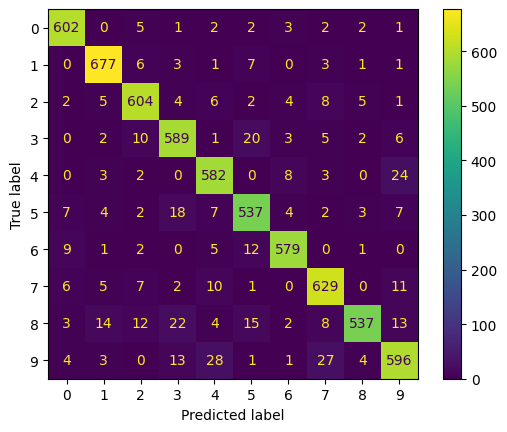

Avg loss =  0.00208959154387331  Accuracy =  0.9271647389809315


In [55]:
n_epochs = 10
net_filename = "net_filemame.txt"
opti_filename = "opti1"
best_loss = 10 ** 4

for epoch in range(1, n_epochs + 1):
    # Perform training once on the entire set of training data
    train(dense_net_small, epoch, train_dload_small)  
    
    # Evaluate the net using validation data
    val_loss = test(dense_net_small, val_dload)
    
    # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
    # can always be retrieved afterwards. 
    if val_loss < best_loss:
        print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))
        
        # Save the network
        torch.save(dense_net_small.state_dict(), './results/{}.pth'.format(net_filename))
        # Save the optimizer, in case we want to continue training later
        torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
        # Update the best loss to the current loss
        best_loss = val_loss

In [18]:
dense_net = DenseNet()
net_filename = "net_filemame.txt"

network_state_dict = torch.load('./results/{}.pth'.format(net_filename))
dense_net.load_state_dict(network_state_dict)

<All keys matched successfully>

##### Uppgift 4.3
Experimentera er fram till ett nätverk som presterar bra (>96% accuracy) på det stora träningssetet genom att uppdatera och ändra nätverket i uppgift 3.1

Jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet. Printa båda nätverkens accuracy och deras respektive confusion matrix.

 epoch nummer 1 klar  0.0 %, loss => 0.04890620708465576
 epoch nummer 1 klar  25.0 %, loss => 0.08828163892030716
 epoch nummer 1 klar  50.0 %, loss => 0.05520804971456528
 epoch nummer 1 klar  75.0 %, loss => 0.15755802392959595


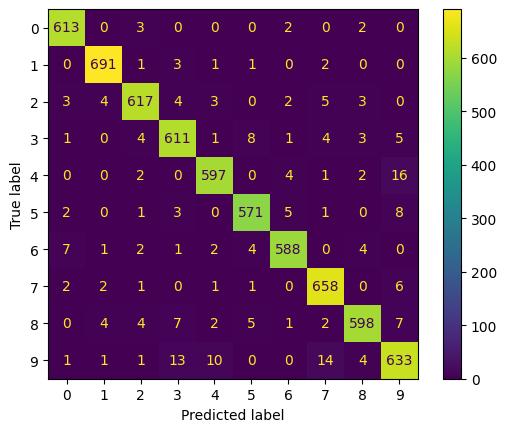

Avg loss =  0.0013506151492788528  Accuracy =  0.9654579556111285
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 2 klar  0.0 %, loss => 0.09427028894424438
 epoch nummer 2 klar  25.0 %, loss => 0.0940573662519455
 epoch nummer 2 klar  50.0 %, loss => 0.050893474370241165
 epoch nummer 2 klar  75.0 %, loss => 0.10954485088586807


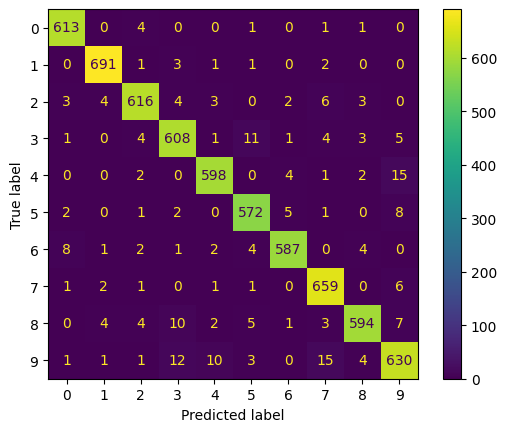

Avg loss =  0.001605283575019534  Accuracy =  0.9640512660206314
 epoch nummer 3 klar  0.0 %, loss => 0.08401207625865936
 epoch nummer 3 klar  25.0 %, loss => 0.0714406967163086
 epoch nummer 3 klar  50.0 %, loss => 0.04350074753165245
 epoch nummer 3 klar  75.0 %, loss => 0.10971609503030777


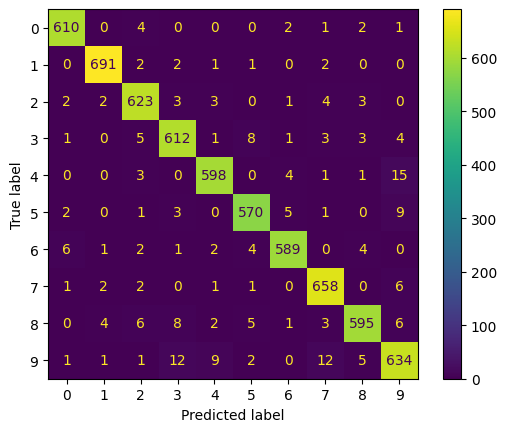

Avg loss =  0.0012410868467131418  Accuracy =  0.9659268521412941
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 4 klar  0.0 %, loss => 0.08030366152524948
 epoch nummer 4 klar  25.0 %, loss => 0.04397749900817871
 epoch nummer 4 klar  50.0 %, loss => 0.028445756062865257
 epoch nummer 4 klar  75.0 %, loss => 0.08101879060268402


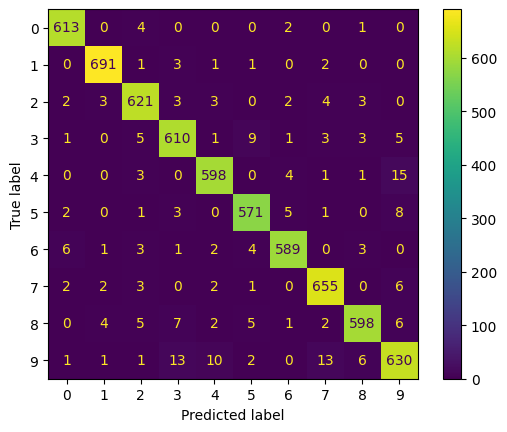

Avg loss =  0.0008523529641132254  Accuracy =  0.9653016567677399
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 5 klar  0.0 %, loss => 0.145674929022789
 epoch nummer 5 klar  25.0 %, loss => 0.07674052566289902
 epoch nummer 5 klar  50.0 %, loss => 0.05036526545882225
 epoch nummer 5 klar  75.0 %, loss => 0.082759328186512


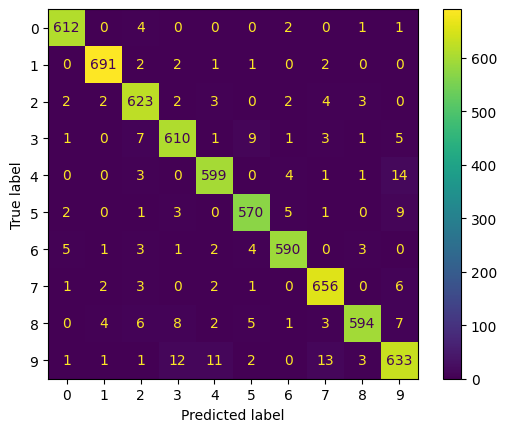

Avg loss =  0.0010498596893712335  Accuracy =  0.965614254454517
 epoch nummer 6 klar  0.0 %, loss => 0.035817794501781464
 epoch nummer 6 klar  25.0 %, loss => 0.060687921941280365
 epoch nummer 6 klar  50.0 %, loss => 0.049195028841495514
 epoch nummer 6 klar  75.0 %, loss => 0.0888713151216507


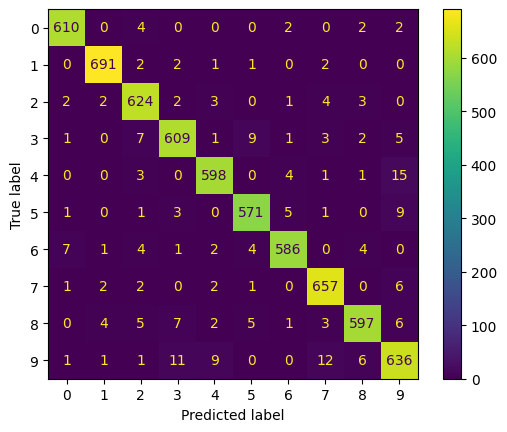

Avg loss =  0.0007970782583722991  Accuracy =  0.9657705532979056
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 7 klar  0.0 %, loss => 0.0568484291434288
 epoch nummer 7 klar  25.0 %, loss => 0.04877760633826256
 epoch nummer 7 klar  50.0 %, loss => 0.11658436805009842
 epoch nummer 7 klar  75.0 %, loss => 0.054779596626758575


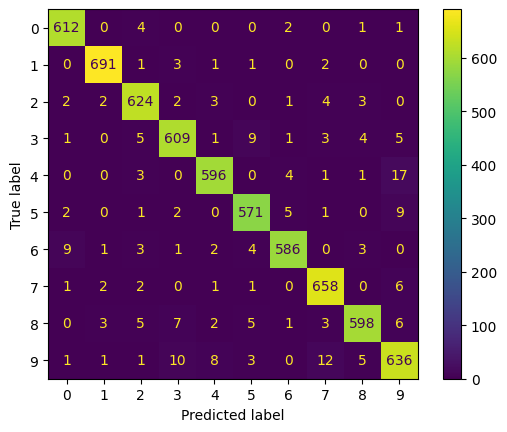

Avg loss =  0.0011842317127749062  Accuracy =  0.9660831509846827
 epoch nummer 8 klar  0.0 %, loss => 0.05691507086157799
 epoch nummer 8 klar  25.0 %, loss => 0.06483862549066544
 epoch nummer 8 klar  50.0 %, loss => 0.06922005861997604
 epoch nummer 8 klar  75.0 %, loss => 0.08575665950775146


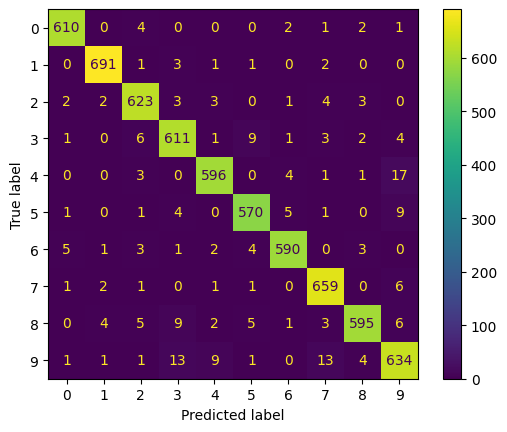

Avg loss =  0.0009196906549972312  Accuracy =  0.9657705532979056
 epoch nummer 9 klar  0.0 %, loss => 0.06417208909988403
 epoch nummer 9 klar  25.0 %, loss => 0.09176163375377655
 epoch nummer 9 klar  50.0 %, loss => 0.044549159705638885
 epoch nummer 9 klar  75.0 %, loss => 0.02700464427471161


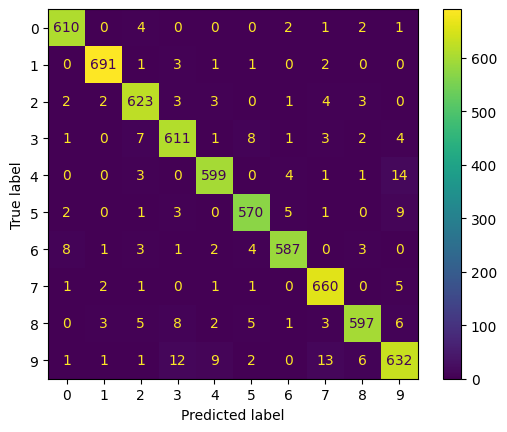

Avg loss =  0.000779572405397718  Accuracy =  0.9659268521412941
Saving best model to ./results/net_filemame.txt.pth

 epoch nummer 10 klar  0.0 %, loss => 0.0579434335231781
 epoch nummer 10 klar  25.0 %, loss => 0.04692262038588524
 epoch nummer 10 klar  50.0 %, loss => 0.07138577848672867
 epoch nummer 10 klar  75.0 %, loss => 0.10391882061958313


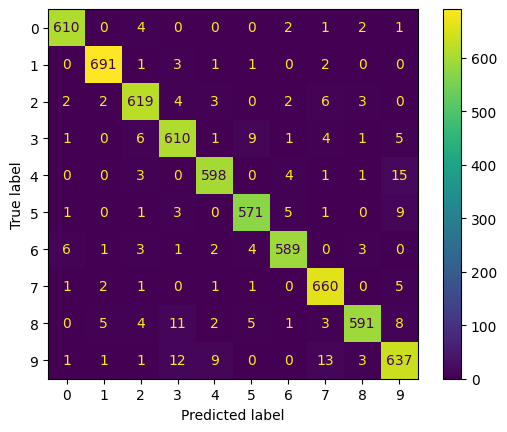

Avg loss =  0.0008482969789870594  Accuracy =  0.9653016567677399


In [19]:
# CODE HERE

# Uppgift 3.2

learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_net.parameters() , lr = learning_rate)

n_epochs = 10
net_filename = "net_filemame.txt"
opti_filename = "opti1"
best_loss = 10 ** 4

for epoch in range(1, n_epochs + 1):
    # Perform training once on the entire set of training data
    train(dense_net, epoch, train_dload)  
    
    # Evaluate the net using validation data
    val_loss = test(dense_net, val_dload)
    
    # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
    # can always be retrieved afterwards. 
    if val_loss < best_loss:
        print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))
        
        # Save the network
        torch.save(dense_net.state_dict(), './results/{}.pth'.format(net_filename))
        # Save the optimizer, in case we want to continue training later
        torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
        # Update the best loss to the current loss
        best_loss = val_loss

### Uppgift 5 - Träna och evaluera SVM:s

1. När vi tränar SVM:s mha scikit-learn så kan vi inte längre använda oss av våra DataLoaders utan behöver därför gå tillbaka till våra dataframes, train_df, train_df_small, val_df och test_df. Skriv kod som separerar varje dataframe i features (pixlar) och labels (klasser) samt normaliserar features [0, 1].
2. Skriv kod för att med hjälp av sklearn och klassen SVC skapa en SVM-modell för bildklassificering.
3. Träna SVM-modellen på träningsdatan.
4. Experimentera er fram till en SVM-modell som presterar bra (>95% accuracy) på det stora träningssetet och jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet.

In [20]:
# Uppgift 5.1
n_training_small = 1000
n_training_large = 25600 

train_df = pd.read_csv("train.csv")  #load training data
test_df = pd.read_csv("test.csv")    #load test data


train_y = train_df["label"]
train_X = train_df.drop(columns=["label"])

train_y_small = train_y.iloc[0:n_training_small].copy()
train_X_small = train_X.iloc[0:n_training_small,:].copy()

train_y_large = train_y.iloc[0:n_training_large].copy()
train_X_large = train_X.iloc[0:n_training_large,:].copy()


val_y = train_y.iloc[n_training_small:].copy()
val_X = train_X.iloc[n_training_small:,:].copy()

test_y = test_df["label"]
test_X = test_df.drop(columns=["label"])

In [21]:
# Uppgift 5.2
# CODE HERE
svm_model_largedata = SVC()
svm_model_samalldata = SVC() 



In [22]:
# Uppgift 5.3
# CODE HERE
svm_model_largedata.fit(train_X_large,train_y_large)
svm_model_samalldata.fit(train_X_small,train_y_small)

# pred = svm_model.predict(test_X)


SVC()

In [23]:
def evaluate_svm_model(model, testX, testy):
    # Make predictions
    y_pred = model.predict(testX)
    
    # Calculate accuracy
    acc = metrics.accuracy_score(y_true=testy, y_pred=y_pred)
    # Create confusion matrix
    cm = metrics.confusion_matrix(testy, y_pred)

    print("Accuracy:", round(acc, 4) * 100, "\n")
    print(cm)

In [24]:
print("SVC for small dataset")
evaluate_svm_model(svm_model_samalldata, val_X, val_y)

print("\n \n SVC for large dataset")
evaluate_svm_model(svm_model_largedata, val_X, val_y)

SVC for small dataset
Accuracy: 92.01 

[[2909    0   18    4    9   17   32    1   20    3]
 [   0 3374   21    8    4   19    6    6    7    4]
 [  17   22 2856   31   52    4   31   31   40    6]
 [   9   18   99 2755    4  140   25   38   94   30]
 [   3   22   20    0 2768    2   17   10   13  183]
 [  12   27   20   50   33 2564   48    6   31   23]
 [  15    8   27    0   20   44 2926    0    9    0]
 [  10   43   52    2   50    4    0 2972    8   97]
 [   9   50   36   84   21   77   17   15 2658   33]
 [  12   14   37   47  117    7    0   82   39 2740]]

 
 SVC for large dataset
Accuracy: 98.47 

[[2993    0    4    1    3    3    3    1    3    2]
 [   0 3421   10    2    3    0    1    6    3    3]
 [   2    5 3047    3    6    1    3   13    9    1]
 [   2    0   13 3146    0   22    1    8   12    8]
 [   3    2    3    0 2993    0    6    2    0   29]
 [   1    0    2   17    3 2773   10    2    3    3]
 [   8    1    1    0    5    8 3021    0    5    0]
 [   2   12   

##### Uppgift 5.4
Experimentera er fram till en SVM-modell som presterar bra (>95% accuracy) på det stora träningssetet genom att uppdatera och ändra modellen i Uppgift 5.2.

Jämför sedan resultatet med en kopia av samma modell som man tränar om med det lilla datasetet. Printa båda modellernas accuracy och deras respektive confusion matrix.

In [25]:
# CODE HERE
# Om man tränar modulen med 80% av dataset får man accuracy på 98% eftersom flera områden kan detekteras vid klasificerng 


print("\n \n SVC for large dataset")
evaluate_svm_model(svm_model_largedata, val_X, val_y)



 
 SVC for large dataset
Accuracy: 98.47 

[[2993    0    4    1    3    3    3    1    3    2]
 [   0 3421   10    2    3    0    1    6    3    3]
 [   2    5 3047    3    6    1    3   13    9    1]
 [   2    0   13 3146    0   22    1    8   12    8]
 [   3    2    3    0 2993    0    6    2    0   29]
 [   1    0    2   17    3 2773   10    2    3    3]
 [   8    1    1    0    5    8 3021    0    5    0]
 [   2   12   14    0   12    0    0 3175    0   23]
 [   1    7    8   13    8    9    3    4 2941    6]
 [   3    3    2   16   27    2    0   22    6 3014]]


### Uppgift 6 - Träna och evaluera CNN

Den sista delen av den här inlämningen är att ni ska implementera och utvärdera ett CNN utifrån de verktyg ni har använt tidigare under uppgiften. En viktig skillnad med convolutions jämfört med FC-lager är att de gradvis minskar storleken på sin output utifrån kernel-size:n (n, m) och att antalet kanaler/channels motsvarar antalet filter i lagret. Exempelvis så kommer en input på 28x28 som körs genom en convolution med kernel-size (3, 4) och stride=1 ge en output som är (28-n+1)x(28-m+1)=26x25. Använder man däremot padding när man genomför sina convolutions så blir input och output lika stora.

I pytorch genomför man convolutions mha:
<pre><code> nn.Conv2d(nr_of_input_filters, nr_of_output_filters, kernel) </pre></code>

För mer information se dokumentationen: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

1. Gör klart implementationen av ett CNN
2. Experimentera fram ett CNN-nätverk som presterar minst lika bra som Dense-nätet.
3. Jämför sedan resultatet med en kopia av samma modell som man tränar om med det lilla datasetet. Printa båda modellernas accuracy och deras respektive confusion matrix.

In [26]:


class ConvModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.kernel = 5
        self.filters = 64
        self.conv_1 = nn.Conv2d(1, self.filters, kernel_size=self.kernel)
        self.conv_2 = nn.Conv2d(self.conv_1.out_channels, self.filters, kernel_size=self.kernel)
        self.conv_3 = nn.Conv2d(self.conv_2.out_channels,64, kernel_size=self.kernel)
        self.fc_1 = nn.Linear(576, 256)
        self.fc_2 = nn.Linear(256, 10)
        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d( kernel_size= (2,2))
        
    def forward(self, x):
        
        x = self.activation(self.conv_1(x))
        x = self.activation(self.pooling(self.conv_2(x)))
        x = self.activation(self.pooling(self.conv_3(x)))
        x = x.view(-1,3*3*64 )
        x = self.activation(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [27]:
conv_net = ConvModel()
learning_rate = 0.0001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(),lr = learning_rate)


print(conv_net)

ConvModel(
  (conv_1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=576, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=10, bias=True)
  (activation): ReLU()
  (pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)


 epoch nummer 1 klar  0.0 %, loss => 2.301149368286133
 epoch nummer 1 klar  25.0 %, loss => 1.100183129310608
 epoch nummer 1 klar  50.0 %, loss => 0.48167192935943604
 epoch nummer 1 klar  75.0 %, loss => 0.2974071800708771


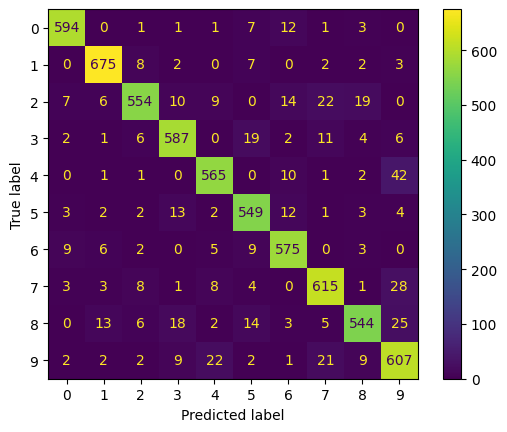

Avg loss =  0.003023539967548887  Accuracy =  0.916692716473898
Saving best model to ./results/convnet.pth

 epoch nummer 2 klar  0.0 %, loss => 0.22930684685707092
 epoch nummer 2 klar  25.0 %, loss => 0.268047571182251
 epoch nummer 2 klar  50.0 %, loss => 0.22709491848945618
 epoch nummer 2 klar  75.0 %, loss => 0.15874508023262024


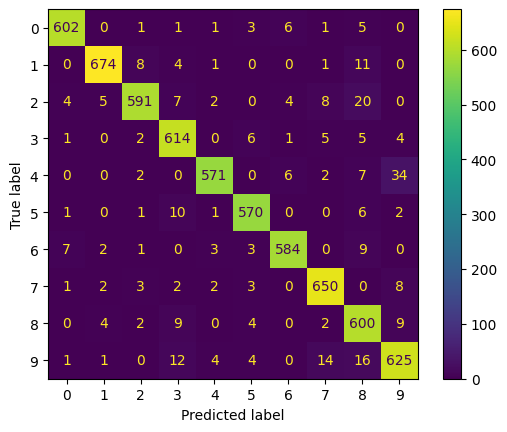

Avg loss =  0.001414215131821237  Accuracy =  0.9504532666458269
Saving best model to ./results/convnet.pth

 epoch nummer 3 klar  0.0 %, loss => 0.11684268712997437
 epoch nummer 3 klar  25.0 %, loss => 0.14671099185943604
 epoch nummer 3 klar  50.0 %, loss => 0.11952518671751022
 epoch nummer 3 klar  75.0 %, loss => 0.2579682469367981


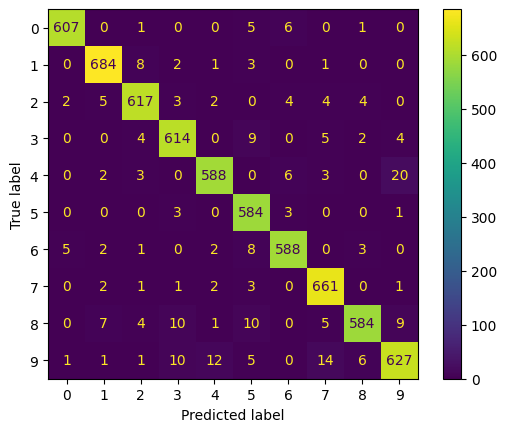

Avg loss =  0.00085500892873947  Accuracy =  0.9618630822131916
Saving best model to ./results/convnet.pth

 epoch nummer 4 klar  0.0 %, loss => 0.047428522258996964
 epoch nummer 4 klar  25.0 %, loss => 0.10290147364139557
 epoch nummer 4 klar  50.0 %, loss => 0.07544463127851486
 epoch nummer 4 klar  75.0 %, loss => 0.08095987141132355


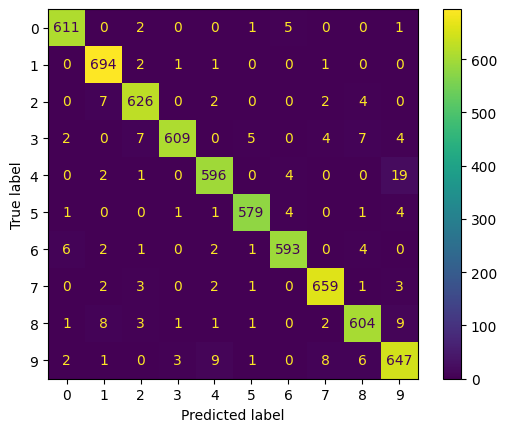

Avg loss =  0.00039990513719423903  Accuracy =  0.9718662081900594
Saving best model to ./results/convnet.pth

 epoch nummer 5 klar  0.0 %, loss => 0.08725380152463913
 epoch nummer 5 klar  25.0 %, loss => 0.028525760397315025
 epoch nummer 5 klar  50.0 %, loss => 0.09523528069257736
 epoch nummer 5 klar  75.0 %, loss => 0.03364371135830879


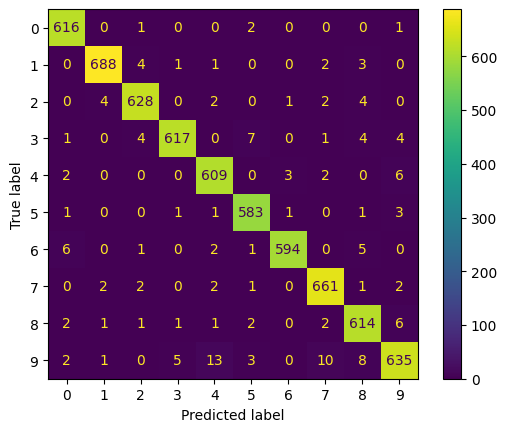

Avg loss =  0.0004106212848296977  Accuracy =  0.9760862769615505
 epoch nummer 6 klar  0.0 %, loss => 0.05316407233476639
 epoch nummer 6 klar  25.0 %, loss => 0.04223821312189102
 epoch nummer 6 klar  50.0 %, loss => 0.06636596471071243
 epoch nummer 6 klar  75.0 %, loss => 0.07449023425579071


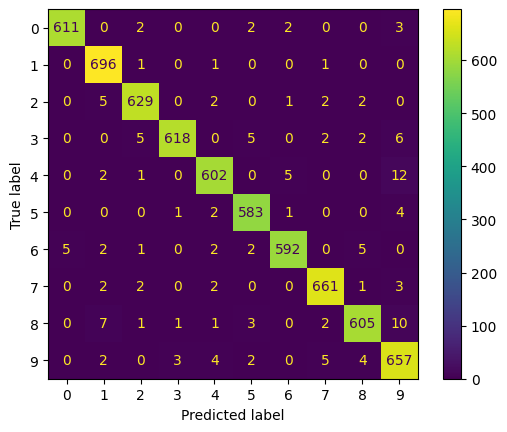

Avg loss =  0.00045096450240230676  Accuracy =  0.9774929665520475
 epoch nummer 7 klar  0.0 %, loss => 0.031752634793519974
 epoch nummer 7 klar  25.0 %, loss => 0.055011387914419174
 epoch nummer 7 klar  50.0 %, loss => 0.04565688222646713
 epoch nummer 7 klar  75.0 %, loss => 0.033323023468256


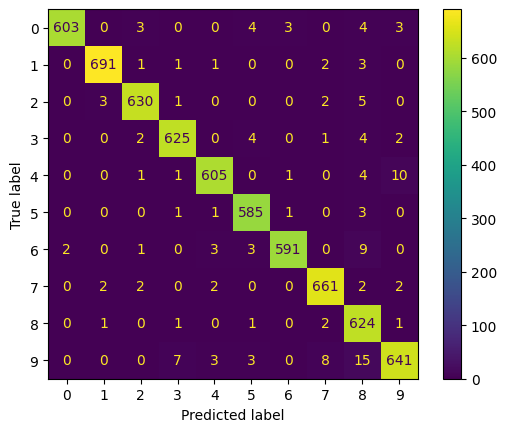

Avg loss =  0.0008962335894116294  Accuracy =  0.9778055642388246
 epoch nummer 8 klar  0.0 %, loss => 0.031076421961188316
 epoch nummer 8 klar  25.0 %, loss => 0.10662566125392914
 epoch nummer 8 klar  50.0 %, loss => 0.04363393783569336
 epoch nummer 8 klar  75.0 %, loss => 0.05634522810578346


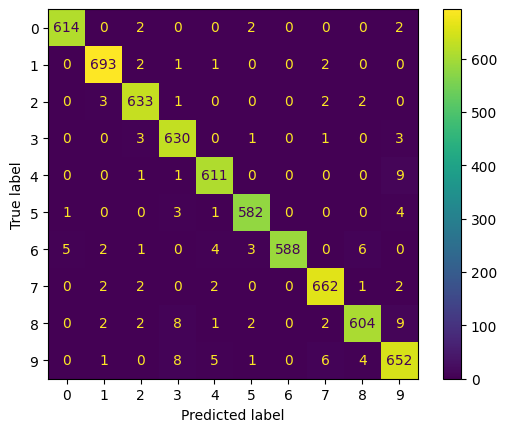

Avg loss =  0.00021883328269715923  Accuracy =  0.9798374492028759
Saving best model to ./results/convnet.pth

 epoch nummer 9 klar  0.0 %, loss => 0.049960989505052567
 epoch nummer 9 klar  25.0 %, loss => 0.012380532920360565
 epoch nummer 9 klar  50.0 %, loss => 0.1324719935655594
 epoch nummer 9 klar  75.0 %, loss => 0.04331829026341438


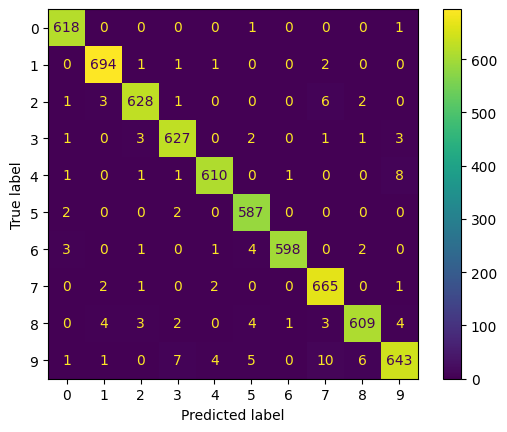

Avg loss =  0.00140569722660486  Accuracy =  0.9814004376367614
 epoch nummer 10 klar  0.0 %, loss => 0.016545003280043602
 epoch nummer 10 klar  25.0 %, loss => 0.03574588894844055
 epoch nummer 10 klar  50.0 %, loss => 0.05258135497570038
 epoch nummer 10 klar  75.0 %, loss => 0.012069044634699821


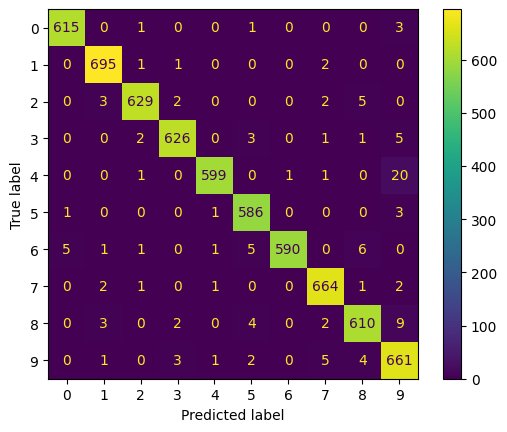

Avg loss =  0.00034269559574344027  Accuracy =  0.9807752422632072


In [28]:
# # Uppgift 6.2
# # CODE HERE

n_epochs = 10
net_filename = "convnet"
opti_filename = "opti2"
best_loss = 10 ** 4

for epoch in range(1, n_epochs + 1):
    # Perform training once on the entire set of training data
    train(conv_net, epoch, train_dload)  
    
    # Evaluate the net using validation data
    val_loss = test(conv_net, val_dload)
    
    # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
    # can always be retrieved afterwards. 
    if val_loss < best_loss:
        print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))
        
        # Save the network
        torch.save(dense_net.state_dict(), './results/{}.pth'.format(net_filename))
        # Save the optimizer, in case we want to continue training later
        torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
        # Update the best loss to the current loss
        best_loss = val_loss





In [48]:
conv_net_smalldata = ConvModel()
learning_rate = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net_smalldata.parameters(),lr = learning_rate)


print(conv_net_smalldata)

ConvModel(
  (conv_1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=576, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=10, bias=True)
  (activation): ReLU()
  (pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)


 epoch nummer 1 klar  0.0 %, loss => 2.3030998706817627


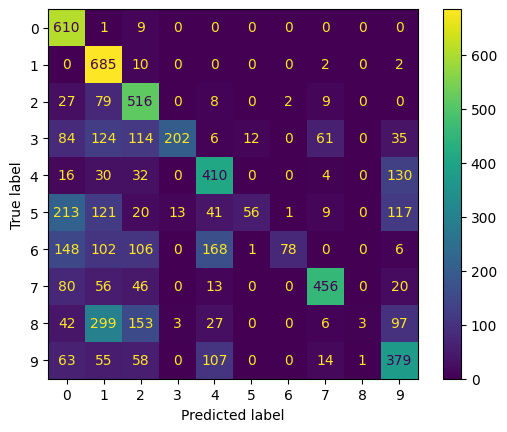

Avg loss =  0.012300678265052835  Accuracy =  0.5306345733041575
Saving best model to ./results/convnet.pth

 epoch nummer 2 klar  0.0 %, loss => 1.5183223485946655


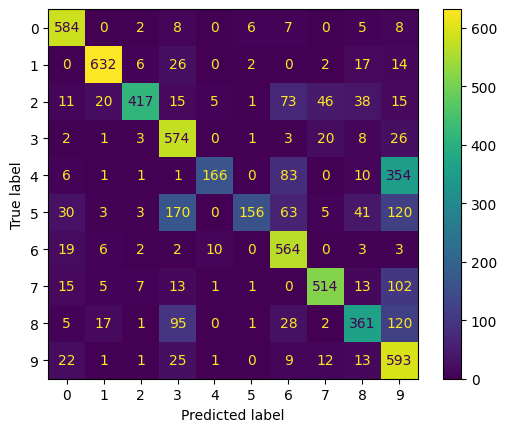

Avg loss =  0.007656987856703091  Accuracy =  0.7128790246952172
Saving best model to ./results/convnet.pth

 epoch nummer 3 klar  0.0 %, loss => 0.8650012612342834


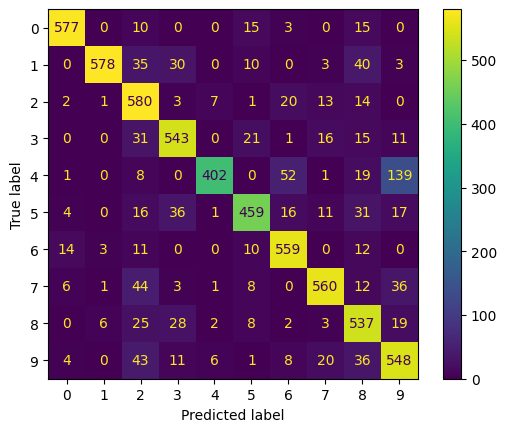

Avg loss =  0.004590433021195071  Accuracy =  0.8351047202250703
Saving best model to ./results/convnet.pth

 epoch nummer 4 klar  0.0 %, loss => 0.47871366143226624


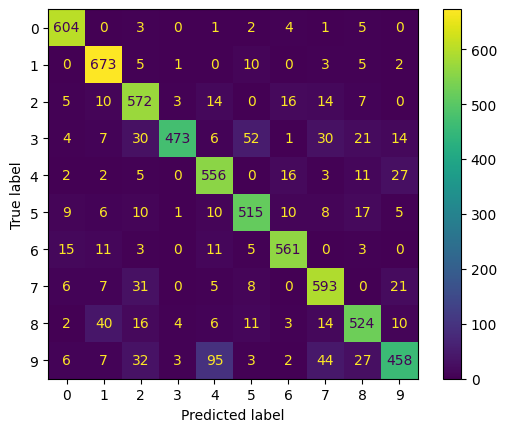

Avg loss =  0.004113943590125487  Accuracy =  0.8641763050953423
Saving best model to ./results/convnet.pth

 epoch nummer 5 klar  0.0 %, loss => 0.3076217472553253


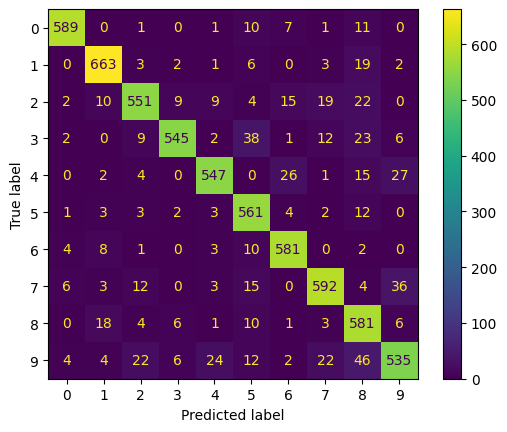

Avg loss =  0.0025964861620925827  Accuracy =  0.8979368552672711
Saving best model to ./results/convnet.pth

 epoch nummer 6 klar  0.0 %, loss => 0.183877095580101


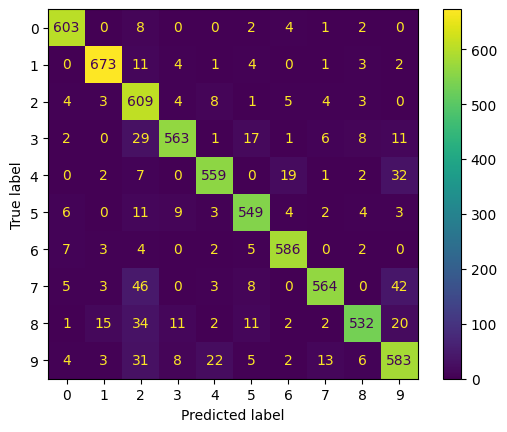

Avg loss =  0.0023225547706944927  Accuracy =  0.9098155673648015
Saving best model to ./results/convnet.pth

 epoch nummer 7 klar  0.0 %, loss => 0.24861574172973633


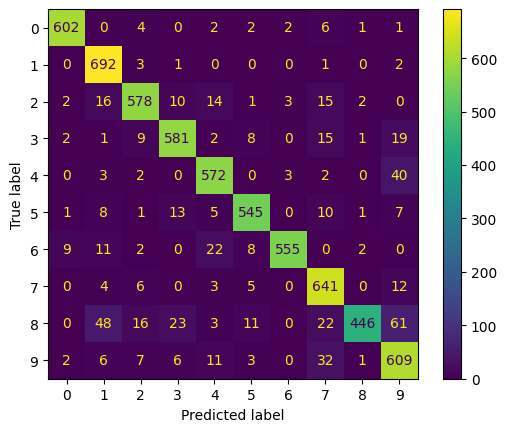

Avg loss =  0.002925063992762294  Accuracy =  0.9098155673648015
 epoch nummer 8 klar  0.0 %, loss => 0.16991916298866272


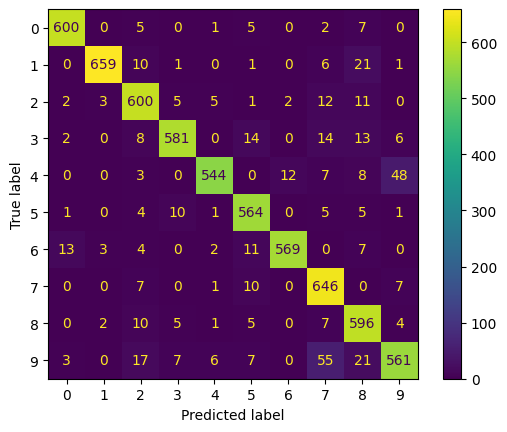

Avg loss =  0.0015070462834548919  Accuracy =  0.9252891528602688
Saving best model to ./results/convnet.pth

 epoch nummer 9 klar  0.0 %, loss => 0.11807289719581604


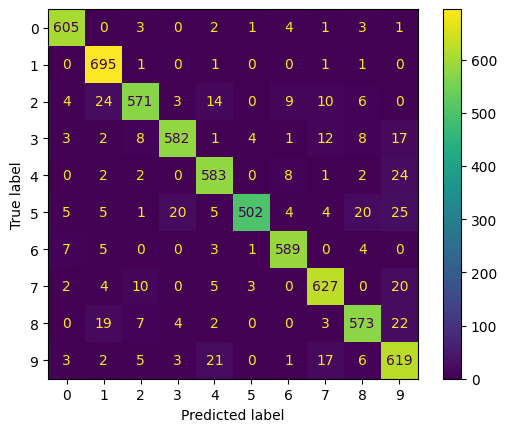

Avg loss =  0.0009074833002133092  Accuracy =  0.9293529227883713
Saving best model to ./results/convnet.pth

 epoch nummer 10 klar  0.0 %, loss => 0.05203060060739517


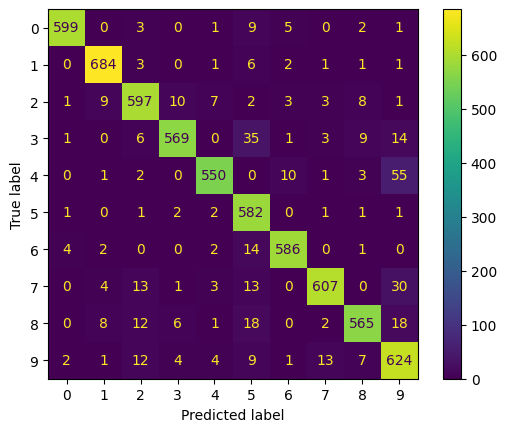

Avg loss =  0.001747879679752894  Accuracy =  0.9320100031259768


In [49]:
# # Uppgift 6.2
# # CODE HERE

n_epochs = 10
net_filename = "convnet"
opti_filename = "opti2"
best_loss = 10 ** 4

for epoch in range(1, n_epochs + 1):
    # Perform training once on the entire set of training data
    train(conv_net_smalldata, epoch, train_dload_small)  
    
    # Evaluate the net using validation data
    val_loss = test(conv_net_smalldata, val_dload)
    
    # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
    # can always be retrieved afterwards. 
    if val_loss < best_loss:
        print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))
        
        # Save the network
        torch.save(dense_net.state_dict(), './results/{}.pth'.format(net_filename))
        # Save the optimizer, in case we want to continue training later
        torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
        # Update the best loss to the current loss
        best_loss = val_loss





### Uppgift 7 - Jämför restultaten på test-setet

Gör en jämförelse av de tre sätten att klassificera på utifrån de resultat ni har fått på test-setet, både för det stora och det lilla setet med träningsdata. Komplettera er jämförelse med grafer, resultat, kod eller annat som stärker er argumentation i första rutan nedan och skriv en kort beskrivning av era slutsatser i rutan under det.

CNN small dataset


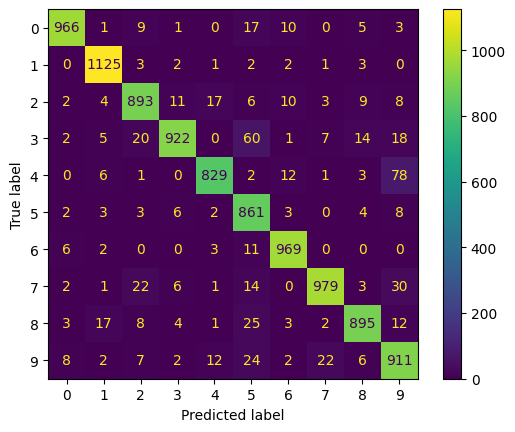

Avg loss =  2107.257285617597  Accuracy =  0.9348130373925215
CNN


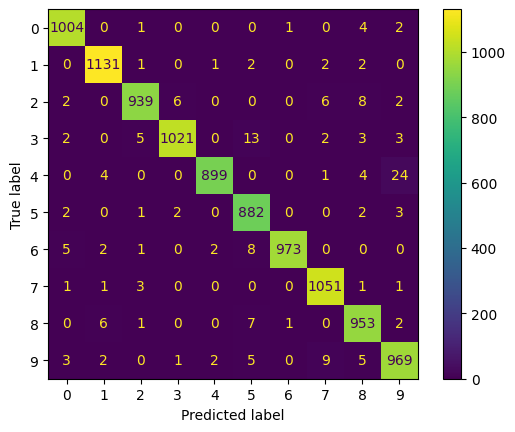

Avg loss =  552.1027605521454  Accuracy =  0.982003599280144

 
 SVC for large dataset
Accuracy: 97.44 

[[1002    0    0    0    0    1    5    0    4    0]
 [   0 1128    3    1    1    1    0    1    3    1]
 [   3    0  940    5    1    0    5    3    3    3]
 [   1    2    9 1015    0    7    0    5    6    4]
 [   0    4    1    0  905    0    5    1    2   14]
 [   5    2    3   10    3  856    7    0    4    2]
 [   5    2    0    0    2    3  979    0    0    0]
 [   2    3    5    0    2    0    0 1036    2    8]
 [   1    8    1    3    3    6    2    1  943    2]
 [   3    4    3    9   11    3    0   12    9  942]]

 
 SVC for small dataset
Accuracy: 92.21000000000001 

[[ 980    0    4    0    1    3   13    0   10    1]
 [   0 1118    4    5    1    3    2    0    4    2]
 [   5    4  888    9   11    3    9    7   22    5]
 [   5   12   40  896    2   38   12   10   27    7]
 [   1    9    5    0  849    1    5    1    5   56]
 [   5   10    7   17   10  805   20    1  

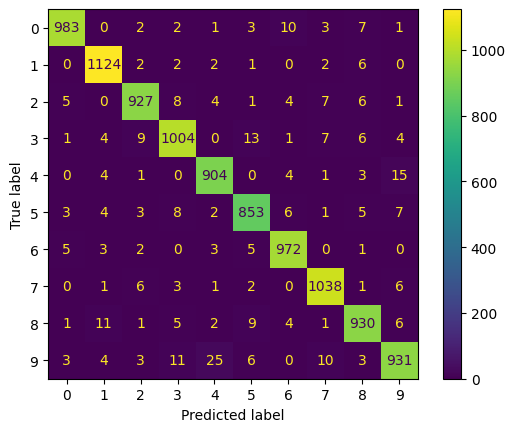

Avg loss =  1109.2530289915555  Accuracy =  0.9664067186562687
NN small data


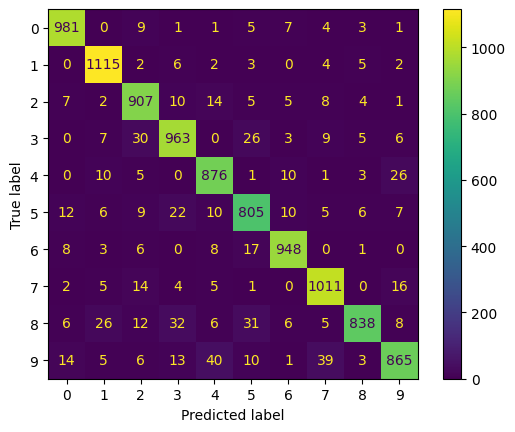

Avg loss =  2363.6164801148757  Accuracy =  0.9307138572285543


2363.6164801148757

In [57]:
# CODE HERE
#CNN LARGE AND SMALL DATA
print("CNN small dataset")
test(conv_net_smalldata, test_dload)
print("CNN")
test(conv_net, test_dload)

#CNN LARGE AND SMALL DATA
print("\n \n SVC for large dataset")
evaluate_svm_model(svm_model_largedata, test_X, test_y)
print("\n \n SVC for small dataset")
evaluate_svm_model(svm_model_samalldata, test_X, test_y)


#NN LARGE AND SMALL DATA
print("NN")
test(dense_net, test_dload)
print("NN small data")
test(dense_net_small, test_dload)

# TEXT HERE
 
Resultat av gämförelse gav att CNN är bäst på att klassificera bilder. Det var förväntat eftesom kernels gör att näverket blir mer flexibelt som leder till bättre igenkänning av olika objekt/mönster. SVC var näst bästa men den var det lättaste och snabbaste sättet att få datan presenterad på så bra prestanda. Sist är det NN som gav det sämsta resultatet. Man kan även dra en slutsats att NN och CNN behöver stora data sätt för att få en någorlunda bra resultat, däremot kan SVC hade bättre resultat vid mindre data mängd. Vi kan även se att vid small dataset har CNN bäst accuracy vilket är 93.4 %. Det skiljer inte sig så mycket från NN som har 93.0% och från SVC som är 92.2%. 
Vi tror att när man inte har mycket data att arbeta med och man vill visualisera och evaluera snabbt så är det bäst att använda sig av SVC eftesom det är snabbast och enklast att arbeta med.

### Uppgift 8 - Ungefär hur många timmar har gruppen lagt på att göra klart inlämningen

In [ ]:
# TEXT HERE
# Abdulrahman Hameshli: 20 timmar 
# Philip Fredriksso 20 timar